# San Francisco Crime Classification
- Predict the category of crimes that occurred in the city by the bay

$$ logloss={-\frac{1}{N}}\sum_{i=1}^N\sum_{j=1}^My_{ij}log(p_{ij})$$

## 1. Overview

### 1) Data Shape

In [1]:
df_train = pd.read_csv("train.csv", parse_dates=['Dates'])

In [14]:
df_test = pd.read_csv("test.csv", parse_dates=['Dates'])

In [2]:
df_train.shape, df_test.shape

((878049, 9), (884262, 7))

In [3]:
df_train.tail()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.394926,37.738212


### 2) column 설명

##### 1. Dates (사건일자)
: timestamp of the crime incident
##### 2. Category (범죄유형 - 종속변수)
: category of the crime incident (only in train.csv). This is the target variable you are going to predict.
##### 3. Descript (범죄 세부정보)
: detailed description of the crime incident (only in train.csv)
##### 4. DayOfWeek (요일)
: the day of the week
##### 5. PdDistrict (관할서)
: name of the Police Department District
##### 6. Resolution (처벌결과)
: how the crime incident was resolved (only in train.csv)
##### 7. Address (사건현장 대략적 주소)
: the approximate street address of the crime incident 
##### 8. X (경도)
:Longitude
##### 9. Y (위도)
: Latitude

In [16]:
df_test.tail()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
884257,884257,2003-01-01 00:01:00,Wednesday,MISSION,2600 Block of BRYANT ST,-122.408983,37.751987
884258,884258,2003-01-01 00:01:00,Wednesday,NORTHERN,1900 Block of WASHINGTON ST,-122.425342,37.792681
884259,884259,2003-01-01 00:01:00,Wednesday,INGLESIDE,5500 Block of MISSION ST,-122.445418,37.712075
884260,884260,2003-01-01 00:01:00,Wednesday,BAYVIEW,1500 Block of HUDSON AV,-122.387394,37.739479
884261,884261,2003-01-01 00:01:00,Wednesday,TARAVAL,1500 Block of SLOAT BL,-122.489714,37.733950


In [17]:
for i in df_train.columns:
    print(i, "\n", df_train[i].unique(), len(df_train[i].unique()))

Dates 
 ['2015-05-13T23:53:00.000000000' '2015-05-13T23:33:00.000000000'
 '2015-05-13T23:30:00.000000000' ... '2003-01-06T00:20:00.000000000'
 '2003-01-06T00:15:00.000000000' '2003-01-06T00:01:00.000000000'] 389257
Category 
 ['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT'] 39
Descript 
 ['WARRANT ARREST' 'TRAFFIC VIOLATION ARREST'
 'GRAND THEFT FROM LOCKED AUTO' 'GRAND THEFT FROM UNLOCKED AUTO'
 'STOLEN AUTOMOBILE' 'PETTY THEFT FROM LOCKED A

test데이터에 Descript, Resolution column이 없으므로 train에서 Descript, Resolution column 제거 

##### Drop Descript, Resolution in train

In [2]:
df_train.drop(columns=['Descript','Resolution'],inplace=True)

## 2. Feature Extraction
- 시간 : year, month, hour column 추출
- 공간 : isIntersection, isStreet, isBlock 추출
- event : 1 추가

In [3]:
df_train['year'] = df_train['Dates'].map(lambda x: x.year)
df_train['month'] = df_train['Dates'].map(lambda x: x.month)
df_train['hour'] = df_train['Dates'].map(lambda x: x.hour)

In [4]:
df_train.drop(columns='Dates', inplace=True)
df_train.tail()

,Category,DayOfWeek,PdDistrict,Address,X,Y,year,month,hour
878044,ROBBERY,Monday,TARAVAL,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2003,1,0
878045,LARCENY/THEFT,Monday,INGLESIDE,600 Block of EDNA ST,-122.447364,37.731948,2003,1,0
878046,LARCENY/THEFT,Monday,SOUTHERN,5TH ST / FOLSOM ST,-122.403390,37.780266,2003,1,0
878047,VANDALISM,Monday,SOUTHERN,TOWNSEND ST / 2ND ST,-122.390531,37.780607,2003,1,0
878048,FORGERY/COUNTERFEITING,Monday,BAYVIEW,1800 Block of NEWCOMB AV,-122.394926,37.738212,2003,1,0


In [5]:
df = df_train.copy()

In [6]:
# 앞뒤가 뒤바뀐 주소가 존재한다.
print(df[df.Address == "OAK ST / LAGUNA ST"].size)
print(df[df.Address == "LAGUNA ST / OAK ST"].size)

405
243


In [7]:
# 중복된 주소 제거해보자
# 1. Address에서 '/'를 포함한 index추출(교차로) 
idx = df[df.Address.str.contains('/')].index

In [8]:
len(set(df.loc[idx,"Address"]))

12278

In [9]:
a1 = "OAK ST / LAGUNA ST"
a2 = "LAGUNA ST / OAK ST"
result1 = sorted(a1.split(" / "))
result2 = sorted(a2.split(" / "))
print(result1, result2)

['LAGUNA ST', 'OAK ST'] ['LAGUNA ST', 'OAK ST']


In [10]:
renewals = [sorted(address.split(" / ")) for address in df.loc[idx,"Address"]]
renewal_address = np.array([" / ".join(renewal).strip() for renewal in renewals])
renewal_address

array(['LAGUNA ST / OAK ST', 'LAGUNA ST / OAK ST',
       'GREENWICH ST / VANNESS AV', ..., 'CAPITOL AV / FARALLONES ST',
       '5TH ST / FOLSOM ST', '2ND ST / TOWNSEND ST'], dtype='<U44')

In [11]:
# 12278개 교차로 --> 6862개 교차로 : 5416개 중복 제거
len(set(renewal_address))

6862

In [12]:
df.Address.nunique()

23228

In [13]:
df.loc[idx, "Address"] = renewal_address
df.Address.nunique()

17812

In [14]:
# 완료
23228 - 17812

5416

In [15]:
len(df)

878049

In [16]:
idx = df[df.Y == 90.0].index
df.drop(index=idx, inplace=True)
len(df)

877982

In [18]:
def street_addr(x):
    street=x.split(' ')
    return (' '.join(street[-1:]))

In [19]:
df['addr']=df['Address'].apply(lambda x:street_addr(x))
df['addr'].tail()

878044    ST
878045    ST
878046    ST
878047    ST
878048    AV
Name: addr, dtype: object

In [20]:
df['addr'].nunique()

29

In [21]:
df['addr'].unique(),len(df['addr'].unique()) 

(array(['ST', 'AV', 'WY', 'BL', 'DR', 'CT', 'TR', 'HY', 'RD', 'PZ', 'PL',
        'LN', 'WAY', 'CR', 'AL', 'PALMS', 'TER', 'STWY', 'HWY',
        'FERLINGHETTI', 'WK', 'EX', 'RW', 'BUFANO', 'MAR', 'I-80', 'I-280',
        'PARK', '/'], dtype=object), 29)

In [22]:
for i in df['addr'].unique():
    print("addr : ", i, "count :",len(df[df['addr'] == i]))

addr :  ST count : 653093
addr :  AV count : 165490
addr :  WY count : 6940
addr :  BL count : 20892
addr :  DR count : 13798
addr :  CT count : 2933
addr :  TR count : 1304
addr :  HY count : 2618
addr :  RD count : 3951
addr :  PZ count : 2350
addr :  PL count : 1406
addr :  LN count : 1798
addr :  WAY count : 101
addr :  CR count : 466
addr :  AL count : 233
addr :  PALMS count : 84
addr :  TER count : 86
addr :  STWY count : 16
addr :  HWY count : 36
addr :  FERLINGHETTI count : 5
addr :  WK count : 5
addr :  EX count : 12
addr :  RW count : 1
addr :  BUFANO count : 5
addr :  MAR count : 22
addr :  I-80 count : 322
addr :  I-280 count : 4
addr :  PARK count : 7
addr :  / count : 4


In [23]:
df['isStreet'] = np.array([1 if value == 'ST' else 0 for value in df.addr.values])

In [24]:
df["IsInterection"] = df["Address"].apply(lambda x: 1 if "/" in x else 0)

In [25]:
df['event'] = 1

### 3. Exploratory data analysis

##### 1) 요일별 범죄발생수

In [34]:
crime_by_dayofweek = df_train[['Category','DayOfWeek','event']].groupby(['Category','DayOfWeek']).count().reset_index()
crime_by_dayofweek_pivot1 = crime_by_dayofweek.pivot(index='Category',columns='DayOfWeek',values='event')
crime_by_dayofweek_pivot1

DayOfWeek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Category,,,,,,,
ARSON,220.0,228.0,220.0,211.0,199.0,235.0,200.0
ASSAULT,11160.0,10560.0,11995.0,12082.0,10246.0,10280.0,10553.0
BAD CHECKS,62.0,66.0,45.0,20.0,66.0,76.0,71.0
BRIBERY,49.0,41.0,42.0,41.0,39.0,37.0,40.0
BURGLARY,6327.0,5262.0,4754.0,4231.0,5350.0,5374.0,5457.0
DISORDERLY CONDUCT,541.0,608.0,624.0,586.0,644.0,657.0,660.0
DRIVING UNDER THE INFLUENCE,352.0,263.0,457.0,442.0,282.0,251.0,221.0
DRUG/NARCOTIC,7420.0,7823.0,6390.0,6143.0,8454.0,8474.0,9267.0
DRUNKENNESS,622.0,513.0,833.0,813.0,496.0,461.0,542.0


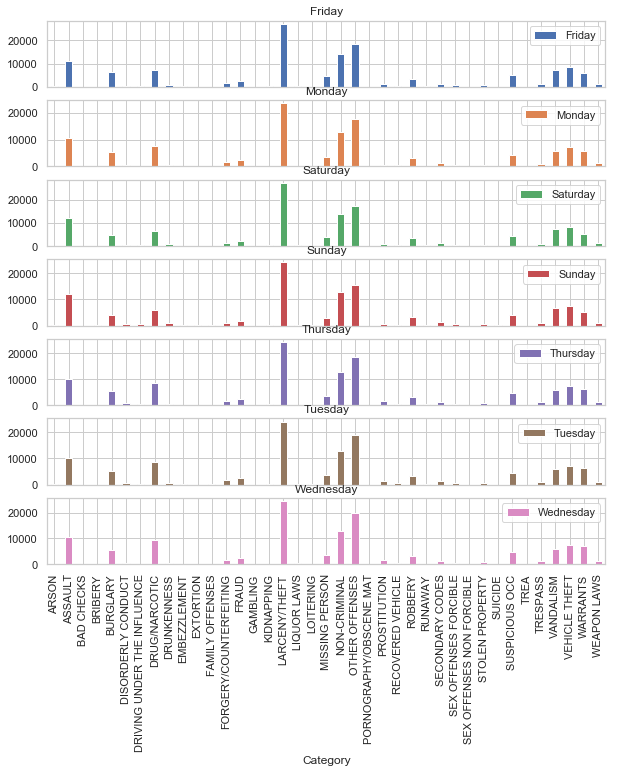

In [36]:
crime_by_dayofweek_pivot1.plot(kind='bar',subplots=True, figsize=(10,10))
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018A40A2A978>,
      dtype=object)

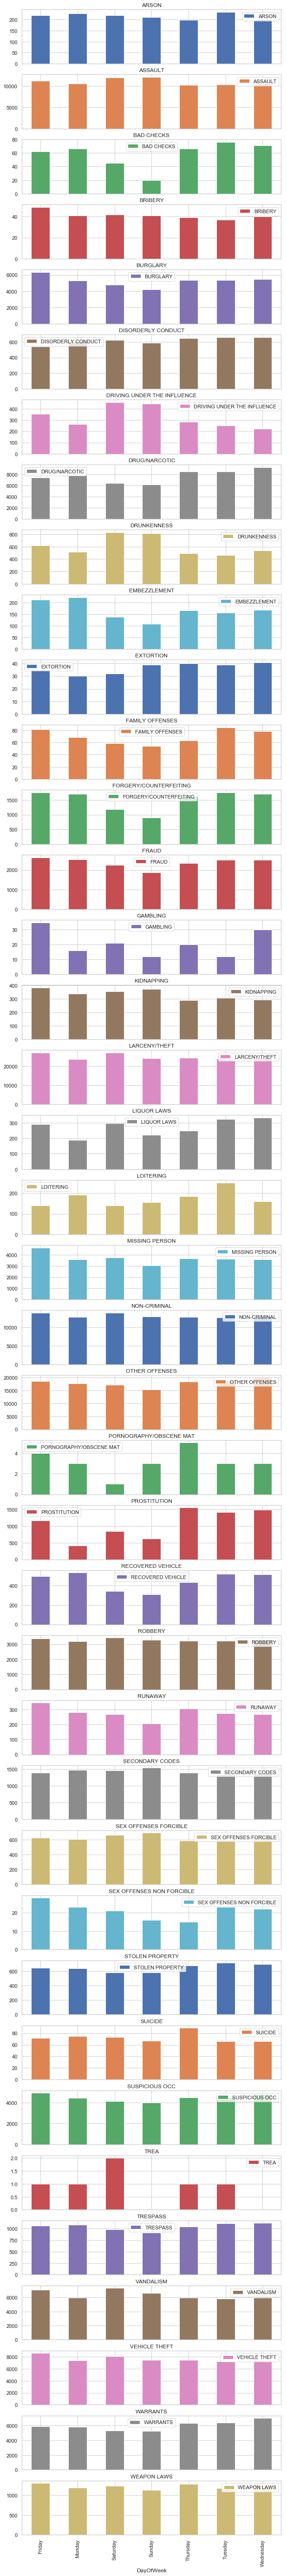

In [42]:
crime_by_dayofweek_pivot2 = crime_by_dayofweek.pivot(index='DayOfWeek',columns='Category',values='event')
crime_by_dayofweek_pivot2.plot(kind='bar', subplots=True, figsize=(10,100),sharex=True)

모든 범죄에서 요일별로 범죄발생수에 차이를 보인다. 

##### 2) 연도별 범죄발생수

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018A45189198>,
      dtype=object)

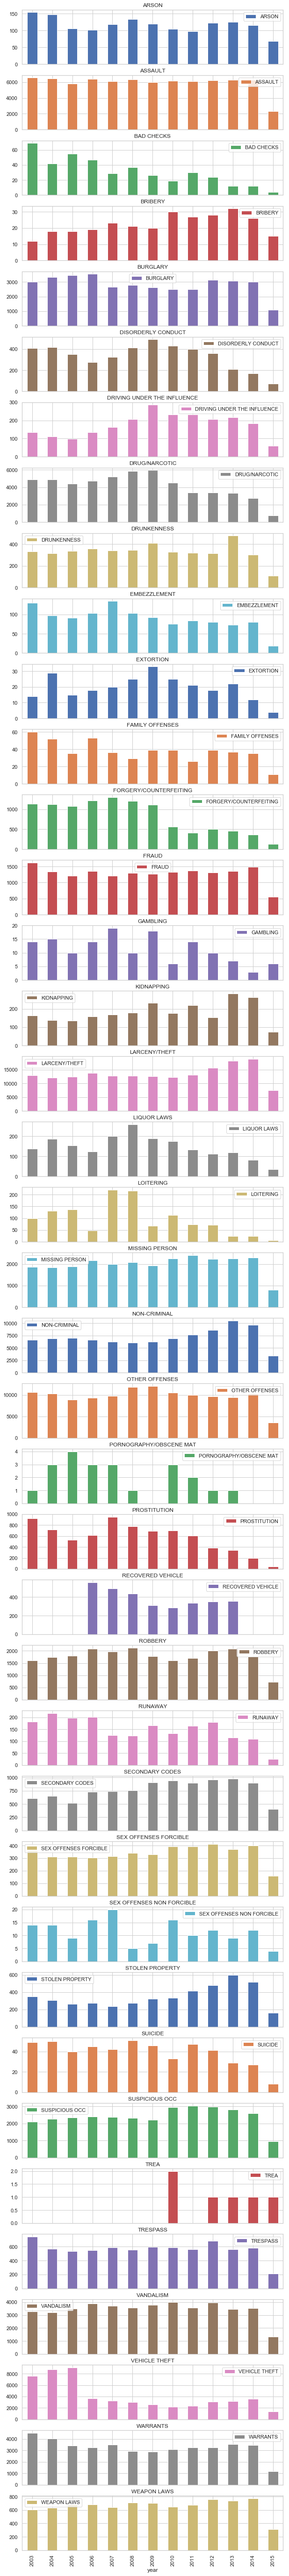

In [44]:
crime_by_year = df_train[['Category','year','event']].groupby(['Category','year']).count().reset_index()
crime_by_year_pivot = crime_by_year.pivot(index='year',columns='Category',values='event')
crime_by_year_pivot.plot(kind='bar', subplots=True, figsize=(10,100))

범죄별로 연도별 범죄발생수에 차이를 보인다.

##### 3) 시간대별 범죄발생수

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018A49268D68>,
      dtype=object)

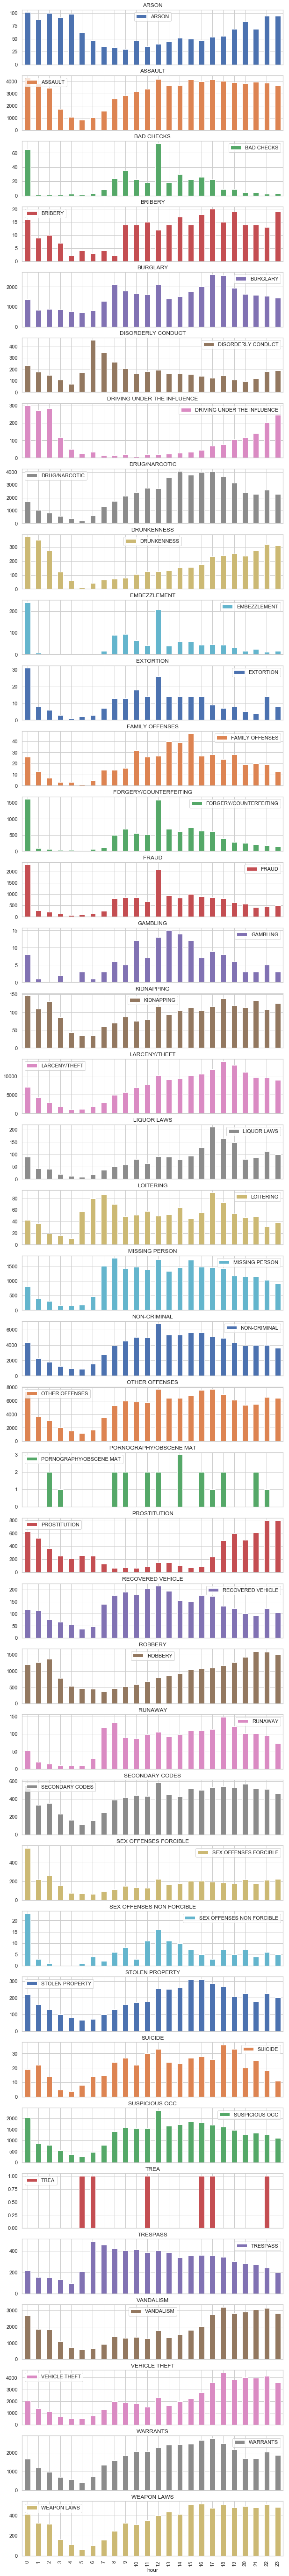

In [45]:
crime_by_hour = df_train[['Category','hour','event']].groupby(['Category','hour']).count().reset_index()
crime_by_hour_pivot = crime_by_hour.pivot(index='hour',columns='Category',values='event')
crime_by_hour_pivot.plot(kind='bar', subplots=True, figsize=(10,100))

범죄별로 시간대별 범죄발생수에 차이를 보인다.

##### 4) 월별 범죄발생수

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018A4C3F00B8>,
      dtype=object)

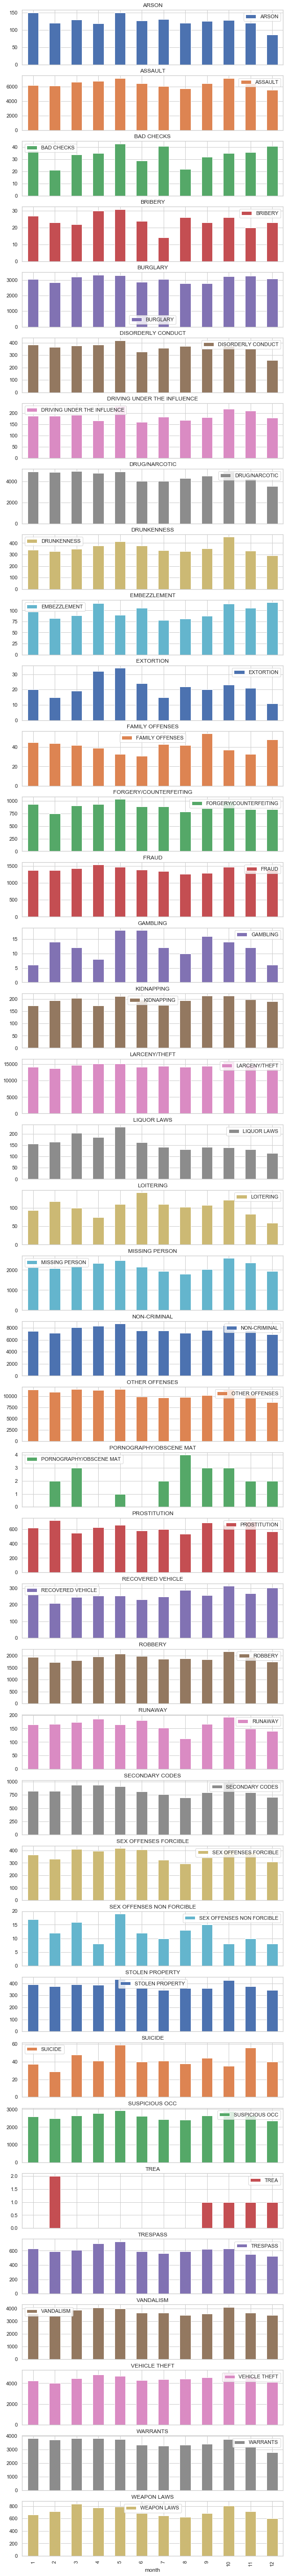

In [46]:
crime_by_month = df_train[['Category','month','event']].groupby(['Category','month']).count().reset_index()
crime_by_month_pivot = crime_by_month.pivot(index='month',columns='Category',values='event')
crime_by_month_pivot.plot(kind='bar', subplots=True, figsize=(10,100))

범죄별로 월별 범죄발생수에 차이를 보인다.

##### 5) 범죄별 범죄발생위치 

In [43]:
crime_address = df[['Category','Address','event']].groupby(['Category','Address']).sum().reset_index()
crime_address.sort_values(by=['Category','event'], ascending=False, inplace=True)

In [49]:
len(crime_address[crime_address.Category == "LARCENY/THEFT"]), crime_address[crime_address.Category == "LARCENY/THEFT"]

(17535,             Category                                Address  event
 55937  LARCENY/THEFT                 800 Block of BRYANT ST   6144
 56053  LARCENY/THEFT                 800 Block of MARKET ST   3256
 47706  LARCENY/THEFT               100 Block of OFARRELL ST   1098
 53263  LARCENY/THEFT                  3200 Block of 20TH AV   1015
 55725  LARCENY/THEFT                 700 Block of MARKET ST    863
 51074  LARCENY/THEFT                2000 Block of MARKET ST    753
 46717  LARCENY/THEFT                   0 Block of PHELAN AV    697
 54823  LARCENY/THEFT           500 Block of JOHNFKENNEDY DR    690
 47750  LARCENY/THEFT                 100 Block of POWELL ST    666
 46739  LARCENY/THEFT                   0 Block of POWELL ST    634
 46667  LARCENY/THEFT                 0 Block of OFARRELL ST    624
 56324  LARCENY/THEFT                 900 Block of MARKET ST    611
 51568  LARCENY/THEFT                  2300 Block of 16TH ST    511
 48878  LARCENY/THEFT               1300 

#### 각 범죄별로 가장 많이 발생한 위치 5군데를 뽑아보자

In [50]:
for crime in crime_address.Category.unique():
    result = crime_address[crime_address.Category == crime]
    print("Crime: ",crime,"\t", "Address count: ",len(result),"\n" ,result.head(),"\n")

Crime:  WEAPON LAWS 	 Address count:  3565 
            Category                    Address  event
169473  WEAPON LAWS     800 Block of BRYANT ST    156
168393  WEAPON LAWS   2000 Block of MISSION ST     77
167176  WEAPON LAWS          0 Block of 6TH ST     44
167431  WEAPON LAWS         0 Block of TURK ST     42
169555  WEAPON LAWS  900 Block of ELLSWORTH ST     37 

Crime:  WARRANTS 	 Address count:  7836 
         Category                   Address  event
163882  WARRANTS    800 Block of BRYANT ST   1719
161754  WARRANTS  2000 Block of MISSION ST    567
163946  WARRANTS    800 Block of MARKET ST    477
159860  WARRANTS        0 Block of TURK ST    392
160343  WARRANTS  1000 Block of POTRERO AV    322 

Crime:  VEHICLE THEFT 	 Address count:  14588 
              Category                     Address  event
147669  VEHICLE THEFT  1500 Block of BAY SHORE BL    162
150974  VEHICLE THEFT    300 Block of OFARRELL ST    145
153595  VEHICLE THEFT      800 Block of BRYANT ST    128
152065  V

- Street별로 카테고리화해본다.
- PdDistrict별로 범죄발생유형이 다를 것이라고 가정.

In [26]:
df['addr'].nunique()

29

In [53]:
crime_by_PdDistrict = df_train[['PdDistrict','Category','event','X','Y']].groupby(['PdDistrict','Category']).agg({'X':'first', 'Y':'first','event':'sum'}).reset_index()
crime_by_PdDistrict

,PdDistrict,Category,X,Y,event
0,BAYVIEW,ARSON,-122.401152,37.738363,393
1,BAYVIEW,ASSAULT,-122.398696,37.754746,9857
2,BAYVIEW,BAD CHECKS,-122.389864,37.737586,34
3,BAYVIEW,BRIBERY,-122.405610,37.732439,56
4,BAYVIEW,BURGLARY,-122.417938,37.726605,3930
5,BAYVIEW,DISORDERLY CONDUCT,-122.398004,37.719033,219
6,BAYVIEW,DRIVING UNDER THE INFLUENCE,-122.398075,37.730039,179
7,BAYVIEW,DRUG/NARCOTIC,-122.381838,37.731104,4498
8,BAYVIEW,DRUNKENNESS,-122.390965,37.734429,243
9,BAYVIEW,EMBEZZLEMENT,-122.391515,37.738038,100


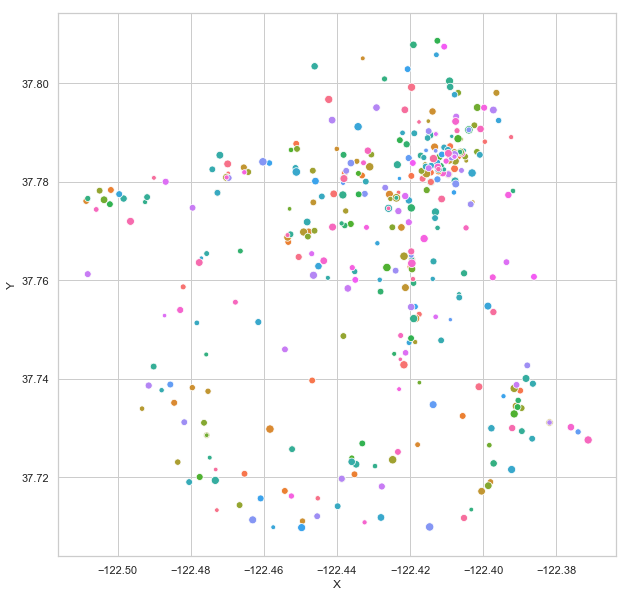

In [67]:
plt.figure(figsize=(10,10))
area = np.pi * crime_by_PdDistrict['event'] ** 10
sns.scatterplot(x='X',y='Y', hue='Category', size=area, data=crime_by_PdDistrict, legend=False)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


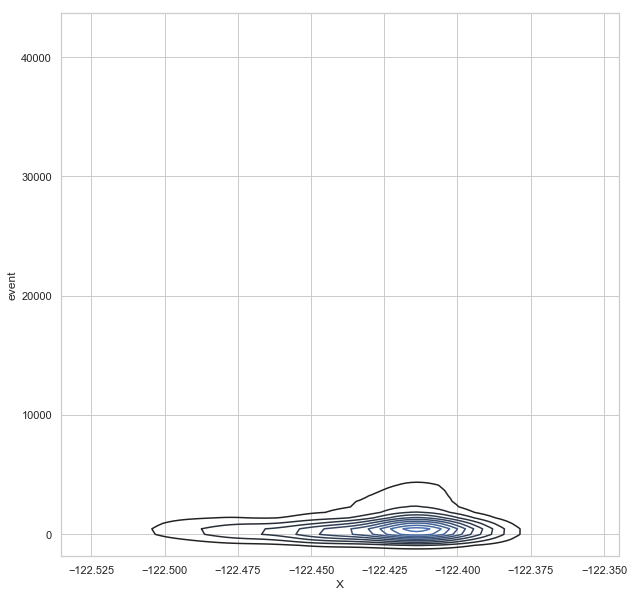

In [69]:
plt.figure(figsize=(10,10))
sns.kdeplot(crime_by_PdDistrict['X'], crime_by_PdDistrict['event'])
plt.show()

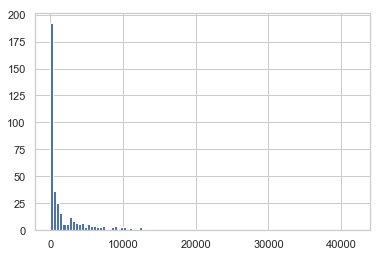

In [74]:
plt.hist(crime_by_PdDistrict['event'], bins=100)
plt.show()

좀 더 develope시켜야 함.

In [14]:
crime_visual = df[['Category','X','Y','event']].groupby(['Category','X','Y']).sum().reset_index()

In [15]:
idx = crime_visual[crime_visual['Y'] == 90.0].index
crime_visual.drop(index=idx, inplace=True)

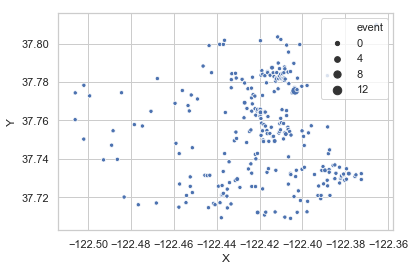

In [99]:
sns.scatterplot(x="X", y="Y", data=crime_visual[crime_visual.Category == 'BRIBERY'], size='event')

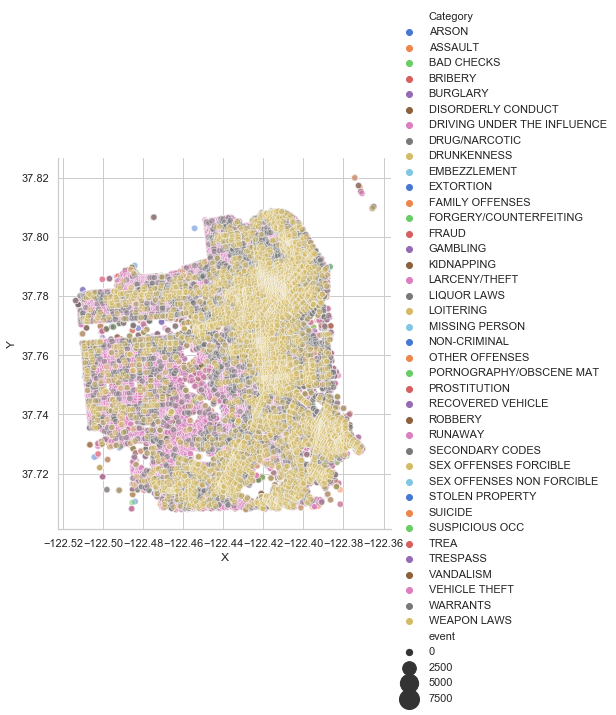

In [16]:
sns.relplot(x="X", y="Y", data=crime_visual, hue='Category', size='event',
            sizes=(40,400), alpha=0.5, palette="muted", height=6)

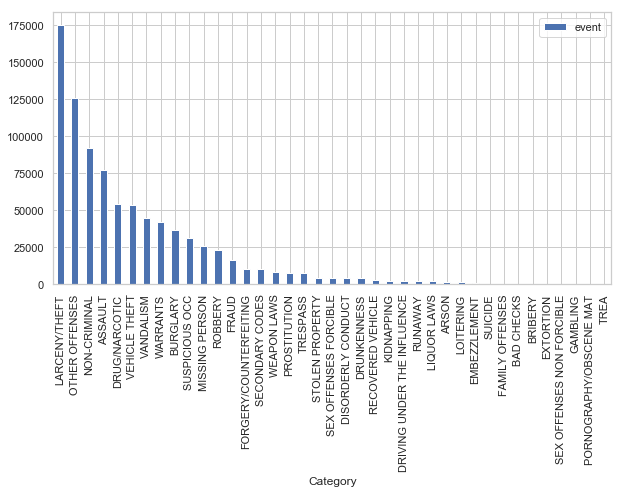

In [65]:
event_crime = df[['Category','event']].groupby('Category').sum().reset_index().sort_values(by="event", ascending=False)
event_crime.plot(kind='bar', x='Category',figsize=(10,5))

In [47]:
df.tail()

,Category,DayOfWeek,PdDistrict,Address,X,Y,year,month,hour,addr,isStreet,IsInterection,event
878044,ROBBERY,Monday,TARAVAL,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2003,1,0,AV,0,1,1
878045,LARCENY/THEFT,Monday,INGLESIDE,600 Block of EDNA ST,-122.447364,37.731948,2003,1,0,ST,1,0,1
878046,LARCENY/THEFT,Monday,SOUTHERN,5TH ST / FOLSOM ST,-122.403390,37.780266,2003,1,0,ST,1,1,1
878047,VANDALISM,Monday,SOUTHERN,TOWNSEND ST / 2ND ST,-122.390531,37.780607,2003,1,0,ST,1,1,1
878048,FORGERY/COUNTERFEITING,Monday,BAYVIEW,1800 Block of NEWCOMB AV,-122.394926,37.738212,2003,1,0,AV,0,0,1


In [52]:
event_isStreet = df[['isStreet','Category','event']].groupby(['isStreet','Category']).count().reset_index()
event_isStreet

,isStreet,Category,event
0,0,ARSON,563
1,0,ASSAULT,21325
2,0,BAD CHECKS,101
3,0,BRIBERY,105
4,0,BURGLARY,10211
5,0,DISORDERLY CONDUCT,895
6,0,DRIVING UNDER THE INFLUENCE,717
7,0,DRUG/NARCOTIC,9511
8,0,DRUNKENNESS,861
9,0,EMBEZZLEMENT,294


In [55]:
sp.stats.ttest_rel(event_isStreet.event[event_isStreet.isStreet == 0], event_isStreet.event[event_isStreet.isStreet == 1])

Ttest_relResult(statistic=-3.403316193897853, pvalue=0.0015817920220961717)

In [1]:
df = pd.read_csv("train_address_preprocessing.csv")
df.tail()

,Category,DayOfWeek,PdDistrict,Address,X,Y,year,month,hour,addr,isStreet,IsInterection,event
878044,ROBBERY,Monday,TARAVAL,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2003,1,0,AV,0,1,1
878045,LARCENY/THEFT,Monday,INGLESIDE,600 Block of EDNA ST,-122.447364,37.731948,2003,1,0,ST,1,0,1
878046,LARCENY/THEFT,Monday,SOUTHERN,5TH ST / FOLSOM ST,-122.403390,37.780266,2003,1,0,ST,1,1,1
878047,VANDALISM,Monday,SOUTHERN,TOWNSEND ST / 2ND ST,-122.390531,37.780607,2003,1,0,ST,1,1,1
878048,FORGERY/COUNTERFEITING,Monday,BAYVIEW,1800 Block of NEWCOMB AV,-122.394926,37.738212,2003,1,0,AV,0,0,1


In [26]:
# Kmeans clustering 해보자(X,Y)
from sklearn.cluster import KMeans

In [27]:
x = df[['X','Y']]

In [ ]:
model_kmeans = KMeans(n_clusters=20, init="k-means++", max_iter=300, n_jobs=3).fit(x)

In [55]:
model_kmeans.score(x)

-54.39584249538893

In [56]:
model_kmeans2 = KMeans(n_clusters=30, init="k-means++", max_iter=300, n_jobs=3).fit(x)

In [58]:
model_kmeans2.score(x)

-34.33321973879356

In [51]:
model_cluster = KMeans(n_clusters=45, init='k-means++', max_iter=300, n_jobs=3, random_state=0).fit(x)

In [28]:
# for i in range(20,50,5):
#     model_cluster = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_jobs=4).fit(x)
#     print("n_cluster : {}, score : {}".format(i, model_cluster.score(x)))

n_cluster : 20, score : -54.1597829959901
n_cluster : 25, score : -42.800856269419455
n_cluster : 30, score : -33.89092560143399
n_cluster : 35, score : -28.496382431410893
n_cluster : 40, score : -24.441776229181414
n_cluster : 45, score : -21.357813225258724


In [52]:
df['XY_cluster45'] = model_cluster.labels_

In [53]:
len(set(model_cluster.labels_))

45

In [3]:
x1 = pd.get_dummies(df[['DayOfWeek','PdDistrict','year','month','hour','XY_cluster45']], columns=['DayOfWeek','PdDistrict','year','month','hour','XY_cluster45'], sparse=False)
x2 = df[['isStreet','IsInterection']]
x = pd.concat([x1,x2], axis=1)
x.tail()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,...,XY_cluster45_37,XY_cluster45_38,XY_cluster45_39,XY_cluster45_40,XY_cluster45_41,XY_cluster45_42,XY_cluster45_43,XY_cluster45_44,isStreet,IsInterection
877977,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
877978,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
877979,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
877980,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
877981,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, log_loss
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from imblearn.under_sampling import *
from imblearn.combine import *
from imblearn.over_sampling import *
import lightgbm as lgb
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.cluster import KMeans

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
y0 = df['Category']

le = LabelEncoder().fit(y0)
y = le.transform(y0)

In [6]:
y.shape

(877982,)

In [58]:
df.to_csv("clustering_XY.csv", index=False)

In [1]:
df = pd.read_csv("clustering_XY.csv")

In [2]:
df.tail()

,Category,DayOfWeek,PdDistrict,Address,X,Y,year,month,hour,addr,isStreet,IsInterection,event,XY_cluster45
877977,ROBBERY,Monday,TARAVAL,CAPITOL AV / FARALLONES ST,-122.459033,37.714056,2003,1,0,ST,1,1,1,7
877978,LARCENY/THEFT,Monday,INGLESIDE,600 Block of EDNA ST,-122.447364,37.731948,2003,1,0,ST,1,0,1,2
877979,LARCENY/THEFT,Monday,SOUTHERN,5TH ST / FOLSOM ST,-122.403390,37.780266,2003,1,0,ST,1,1,1,23
877980,VANDALISM,Monday,SOUTHERN,2ND ST / TOWNSEND ST,-122.390531,37.780607,2003,1,0,ST,1,1,1,23
877981,FORGERY/COUNTERFEITING,Monday,BAYVIEW,1800 Block of NEWCOMB AV,-122.394926,37.738212,2003,1,0,AV,0,0,1,20


##### oversampling

In [9]:
from imblearn.over_sampling import RandomOverSampler
x_sampled, y_sampled = RandomOverSampler(random_state=0).fit_sample(x,y)

In [10]:
x_sampled.shape

(6820515, 113)

In [11]:
le.classes_

array(['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
       'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE',
       'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION',
       'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING',
       'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING',
       'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES',
       'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE',
       'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE',
       'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE',
       'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT',
       'WARRANTS', 'WEAPON LAWS'], dtype=object)

In [12]:
sum(y_sampled == 33)

174885

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_sampled, y_sampled, test_size=0.33, shuffle=True, random_state=0)

In [33]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.4, shuffle=True, random_state=1)

##### model : Logistic Regression

In [34]:
model_logi = LogisticRegression(n_jobs=3, random_state=1).fit(x_train2, y_train2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  " = {}.".format(self.n_jobs))


In [35]:
log_loss(y_test2, model_logi.predict_proba(x_test2))

2.4975626037165495

In [ ]:
# After RandomOverSampling
# model_logi2 = LogisticRegression(n_jobs=4).fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


이건 너무 시간이 오래 걸림.

In [ ]:
# log_loss(y_test, model_logi2.predict_proba(x_test))

##### model : Bernoulli NB

In [22]:
model_bernNB = OneVsRestClassifier(BernoulliNB(),n_jobs=2).fit(x_train2, y_train2)

In [23]:
log_loss(y_test2, model_bernNB.predict_proba(x_test2))

2.5880754961695653

In [ ]:
# After RandomOverSampling
model_bernNB = OneVsRestClassifier(BernoulliNB(),n_jobs=4).fit(x_train, y_train)

##### model : extraTree, RandomForest

In [48]:
model_extraTree = ExtraTreesClassifier(n_estimators=200, max_depth=8, bootstrap=True, random_state=0, n_jobs=4).fit(x_train, y_train)

In [49]:
log_loss(y_test, model_extraTree.predict_proba(x_test))

2.5576574557559404

In [24]:
model_randomForest = RandomForestClassifier(n_estimators=250, max_depth=8, random_state=0, n_jobs=3, criterion='entropy').fit(x_train, y_train)

In [25]:
log_loss(y_test, model_randomForest.predict_proba(x_test))

3.2427856406037274

In [26]:
model_randomForest2 = RandomForestClassifier(n_estimators=250, max_depth=8, random_state=0, n_jobs=3, criterion='entropy').fit(x_train2, y_train2)

In [27]:
log_loss(y_test2, model_randomForest2.predict_proba(x_test2))

2.5686246963279147

In [28]:
model_randomForest3 = RandomForestClassifier(n_estimators=250, max_depth=10, random_state=0, n_jobs=3).fit(x_train2, y_train2)

In [29]:
log_loss(y_test2, model_randomForest3.predict_proba(x_test2))

2.55404052030087

##### model : LightGBM

In [30]:
model_lgb = lgb.LGBMClassifier(learning_rate=0.05,boosting_type='gbdt',max_depth=7, num_leaves=70, n_estimators=200, objective='multiclass', num_class=39).fit(x_train2, y_train2)

In [31]:
log_loss(y_test2, model_lgb.predict_proba(x_test2))

2.478788551011272

In [50]:
model_lgb_oversampling = lgb.LGBMClassifier(learning_rate=0.05,boosting_type='gbdt',max_depth=7, num_leaves=70, n_estimators=200, objective='multiclass', num_class=39).fit(x_train2, y_train2)

In [51]:
log_loss(y_test, model_lgb_oversampling.predict_proba(x_test))

ValueError: Found input variables with inconsistent numbers of samples: [884262, 2250770]

In [12]:
model_lgb1 = lgb.LGBMClassifier(learning_rate=0.07, boosting_type='gbdt', max_depth=8, num_leaves=70, n_estimators=250, objective='multiclass', random_state=0, num_class=39).fit(x_train2, y_train2)

In [13]:
log_loss(y_test2, model_lgb1.predict_proba(x_test2))

2.470312676041389

In [38]:
model_lgb2 = lgb.LGBMClassifier(learning_rate=0.05, boosting_type='gbdt', max_depth=5, num_leaves=80, n_estimators=250, objective='multiclass', random_state=1, num_class=39).fit(x_train2, y_train2)

In [39]:
log_loss(y_test2, model_lgb2.predict_proba(x_test2))

2.484791082775261

In [68]:
len(set(y_test))

39

### test.csv에 적용

In [15]:
df_test['year'] = df_test['Dates'].map(lambda x: x.year)
df_test['month'] = df_test['Dates'].map(lambda x: x.month)
df_test['hour'] = df_test['Dates'].map(lambda x: x.hour)

In [16]:
df_test.drop(columns='Dates', inplace=True)
df_test.tail()

,Id,DayOfWeek,PdDistrict,Address,X,Y,year,month,hour
884257,884257,Wednesday,MISSION,2600 Block of BRYANT ST,-122.408983,37.751987,2003,1,0
884258,884258,Wednesday,NORTHERN,1900 Block of WASHINGTON ST,-122.425342,37.792681,2003,1,0
884259,884259,Wednesday,INGLESIDE,5500 Block of MISSION ST,-122.445418,37.712075,2003,1,0
884260,884260,Wednesday,BAYVIEW,1500 Block of HUDSON AV,-122.387394,37.739479,2003,1,0
884261,884261,Wednesday,TARAVAL,1500 Block of SLOAT BL,-122.489714,37.733950,2003,1,0


In [17]:
def street_addr(x):
    street=x.split(' ')
    return (' '.join(street[-1:]))

In [18]:
df_test['addr'] = df_test['Address'].apply(lambda x:street_addr(x))
df_test['addr'].tail()

884257    ST
884258    ST
884259    ST
884260    AV
884261    BL
Name: addr, dtype: object

In [19]:
df_test['isStreet'] = np.array([1 if value == 'ST' else 0 for value in df_test.addr.values])

In [20]:
df_test["IsInterection"] = df_test["Address"].apply(lambda x: 1 if "/" in x else 0)

In [21]:
x_test = df_test[['X','Y']]

In [22]:
model_cluster_test = KMeans(n_clusters=45, init='k-means++', max_iter=300, n_jobs=3, random_state=0).fit(x_test)

In [23]:
df_test['XY_cluster45'] = model_cluster_test.labels_

In [24]:
df_test.tail()

,Id,DayOfWeek,PdDistrict,Address,X,Y,year,month,hour,addr,isStreet,IsInterection,XY_cluster45
884257,884257,Wednesday,MISSION,2600 Block of BRYANT ST,-122.408983,37.751987,2003,1,0,ST,1,0,11
884258,884258,Wednesday,NORTHERN,1900 Block of WASHINGTON ST,-122.425342,37.792681,2003,1,0,ST,1,0,5
884259,884259,Wednesday,INGLESIDE,5500 Block of MISSION ST,-122.445418,37.712075,2003,1,0,ST,1,0,4
884260,884260,Wednesday,BAYVIEW,1500 Block of HUDSON AV,-122.387394,37.739479,2003,1,0,AV,0,0,10
884261,884261,Wednesday,TARAVAL,1500 Block of SLOAT BL,-122.489714,37.733950,2003,1,0,BL,0,0,20


In [25]:
x1 = pd.get_dummies(df_test[['DayOfWeek','PdDistrict','year','month','hour','XY_cluster45']], columns=['DayOfWeek','PdDistrict','year','month','hour','XY_cluster45'], sparse=False)
x2 = df_test[['isStreet','IsInterection']]
x_test = pd.concat([x1,x2], axis=1)
x_test.tail()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,...,XY_cluster45_37,XY_cluster45_38,XY_cluster45_39,XY_cluster45_40,XY_cluster45_41,XY_cluster45_42,XY_cluster45_43,XY_cluster45_44,isStreet,IsInterection
884257,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
884258,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
884259,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
884260,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
884261,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
pred = model_lgb1.predict_proba(x_test)

In [27]:
id = df_test[['Id']]
df_prediction = pd.DataFrame(pred, columns=le.classes_)
result = pd.concat([id,df_prediction], axis=1)

In [28]:
result.tail()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
884257,884257,0.001048,0.110215,0.002719,0.000207,0.042709,0.007891,0.001290,0.043065,0.011489,...,0.000118,0.005283,0.000164,0.041359,0.000004,0.008067,0.056090,0.070670,0.057636,0.007068
884258,884258,0.001565,0.088455,0.002584,0.000065,0.067051,0.004613,0.000934,0.025250,0.002582,...,0.000035,0.006900,0.000371,0.046747,0.000003,0.012434,0.052206,0.077540,0.043830,0.006284
884259,884259,0.002536,0.104521,0.008031,0.000141,0.035314,0.003571,0.001206,0.022689,0.002789,...,0.000233,0.004793,0.000204,0.050617,0.000003,0.009189,0.057214,0.120866,0.044443,0.009939
884260,884260,0.004580,0.098311,0.008239,0.000130,0.038392,0.004192,0.000949,0.048098,0.002134,...,0.000216,0.006149,0.000289,0.047786,0.000003,0.008199,0.059155,0.093697,0.058389,0.012117
884261,884261,0.001714,0.088446,0.003027,0.000086,0.035323,0.002512,0.001007,0.034233,0.004775,...,0.000156,0.004368,0.000555,0.074905,0.000003,0.006305,0.049652,0.105103,0.031679,0.007028


In [29]:
result.to_csv("LightGBM_new.csv", index=False)